In [1]:
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500) 

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score

import os
os.chdir('../')

from utils import BERTEmbExtractor, find_best_ccp_aplpha, metrics, FaissExtractor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import joblib
import torch

tqdm.pandas()

data_path = '/home/admin01/vadim/classifier/data'

data = pd.read_csv(data_path + '/' + 'Таблица_данные_опроса_+_часть_из_обогащения.csv')
data = data.drop(columns=['ИНН_x', 'ИНН_y', 'Степень уверенности', 'Кол-во вариантов с таким названием компании'])

df_full = pd.read_excel(data_path + '/Выгрузка_Классификатор_для_передачи_1_заход.xlsx')
cols_to_use = data.columns.difference(df_full.columns).tolist()
data = df_full.merge(data[['Номер'] + cols_to_use], on='Номер', how='left', copy=False)

data = data[data['Карьерная ступень по Классификатору ФОИР'] != 11]
# data = data[data['Карьерная ступень по Классификатору ФОИР'] <= 5]


num_cols = ['Уставный капитал, сумма', 'Среднесписочная численность сотрудников', 'Сумма уплаченных налогов за 2020', 'age']

cat_cols = ['Вид экономической деятельности, ОКВЭД', 
            'Доп вид экономической деятельности_1',
            'Доп вид экономической деятельности_2', 
            'Доп вид экономической деятельности_3',
            'Уставный капитал, тип',
            'Тип по ОКОГУ',
            'Категория из реестра СМП'
            ]

tasks = ['Сфера деятельности по Классификатору ФОИР', 'Карьерная ступень по Классификатору ФОИР']
# tasks = ['Наименование выбранной типовой должности', 'Карьерная ступень по Классификатору ФОИР']


# extract age
data['Дата рождения'] = pd.to_datetime(data['Дата рождения'], format="%d.%m.%Y")
data['age'] = pd.Timestamp('now').year - data['Дата рождения'].dt.year

# work with target
LE = [LabelEncoder(), LabelEncoder()]
data['label_a'] = LE[0].fit_transform(data[tasks[0]])
data['label_b'] = LE[1].fit_transform(data[tasks[1]])

text_cols  = ['Место работы', 'Наименование текущей должности']
cat_cols += ['Пол', 'Регион', 'Страна проживания', 'Уровень образования', 'Федеральный округ']
data[text_cols] = data[text_cols].fillna('Пропущенное значение')

# split data
df = data.copy()

df_test = df[df['Ручная проверка карьерной ступени'].notna()][cat_cols + text_cols + num_cols ]
y_test = [df[df['Ручная проверка карьерной ступени'].notna()]['label_a'], 
          df[df['Ручная проверка карьерной ступени'].notna()]['label_b']]

df = df[df['Ручная проверка карьерной ступени'].isna()]
df_train, df_val = train_test_split(df, test_size=.20)

y_train = [df_train['label_a'], df_train['label_b']]
df_train = df_train[cat_cols + text_cols + num_cols].copy()

y_val = [df_val['label_a'], df_val['label_b']]
df_val = df_val[cat_cols + text_cols + num_cols].copy()

/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

In [6]:
text_cols = ['Наименование текущей должности', 'Место работы']

In [10]:
X_train = vectorizer.fit_transform(df_train[text_cols[1]].fillna('Не заполненно').tolist())
X_val = vectorizer.transform(df_val[text_cols[1]].fillna('Не заполненно').tolist())
X_test = vectorizer.transform(df_test[text_cols[1]].fillna('Не заполненно').tolist())

Добавим faiss на похожесть типовым должностям

In [8]:
pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
n_pca = 100

import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


def average_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]


# Each input text should start with "query: " or "passage: ", even for non-English texts.
# For tasks other than retrieval, you can simply use the "query: " prefix.
input_texts = ['query: how much protein should a female eat',
               'query: 南瓜的家常做法',
               "passage: As a general guideline, the CDC's average requirement of protein for women ages 19 to 70 is 46 grams per day. But, as you can see from this chart, you'll need to increase that if you're expecting or training for a marathon. Check out the chart below to see how much protein you should be eating each day.",
               "passage: 1.清炒南瓜丝 原料:嫩南瓜半个 调料:葱、盐、白糖、鸡精 做法: 1、南瓜用刀薄薄的削去表面一层皮,用勺子刮去瓤 2、擦成细丝(没有擦菜板就用刀慢慢切成细丝) 3、锅烧热放油,入葱花煸出香味 4、入南瓜丝快速翻炒一分钟左右,放盐、一点白糖和鸡精调味出锅 2.香葱炒南瓜 原料:南瓜1只 调料:香葱、蒜末、橄榄油、盐 做法: 1、将南瓜去皮,切成片 2、油锅8成热后,将蒜末放入爆香 3、爆香后,将南瓜片放入,翻炒 4、在翻炒的同时,可以不时地往锅里加水,但不要太多 5、放入盐,炒匀 6、南瓜差不多软和绵了之后,就可以关火 7、撒入香葱,即可出锅"]

tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large')

# Tokenize the input texts
batch_dict = tokenizer(input_texts, max_length=512, padding=True, truncation=True, return_tensors='pt')

outputs = model(**batch_dict)
embeddings = average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T) * 100
print(scores.tolist())


In [4]:
bert = BERTEmbExtractor(torch.device('cuda'), n_features=n_pca)
unique_type_name = pd.DataFrame(df['Наименование выбранной типовой должности'].unique())
type_name_emb = bert.fit_transform(unique_type_name).values
# bert = BERTEmbExtractor(torch.device('cuda'), n_features=161)
bert.columns = ['Наименование текущей должности']
name_emb = bert.fit_transform(df[['Наименование текущей должности']]).values

  0%|          | 0/5 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/526 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/526 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTens

In [5]:
type_name_emb.shape

(159, 100)

In [6]:
import faiss

vector_dimension = type_name_emb.shape[1]
index = faiss.IndexFlatL2(vector_dimension)
index.add(type_name_emb)

In [7]:
distances, items = index.search(name_emb, k=3)

In [8]:
col_target = 'Наименование выбранной типовой должности'
col_text = 'Наименование текущей должности'

In [9]:
from sklearn.impute import KNNImputer

In [10]:
# define pipelines and transformer
bert = BERTEmbExtractor(device=torch.device('cuda'), batch_size=32, n_features=n_pca)

data_transformer =  ColumnTransformer([
    ('cat_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('text_encoder', make_pipeline(bert, 
                                   PCA(n_pca)), text_cols),
    ('faiss_extractor', make_pipeline(bert, 
                                      FaissExtractor(index, k=10)), [col_text]),
    ('num_features', 'passthrough', num_cols)
    ], remainder='drop', verbose_feature_names_out=True)

data_prepare = Pipeline([
    ('preproc', data_transformer),
    ('imputer', KNNImputer()),
    ])

In [11]:
# prepare Xs
X_train = data_prepare.fit_transform(df_train)
X_val = data_prepare.transform(df_val)
X_test = data_prepare.transform(df_test)

  0%|          | 0/421 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/421 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/421 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tens

In [51]:
X_train.shape

(59949, 13452)

In [52]:
X_val.shape

(14988, 13452)

In [11]:
from sklearn.ensemble import StackingClassifier

Сфера деятельности по Классификатору ФОИР

Start compute cost_complexity_pruning_path


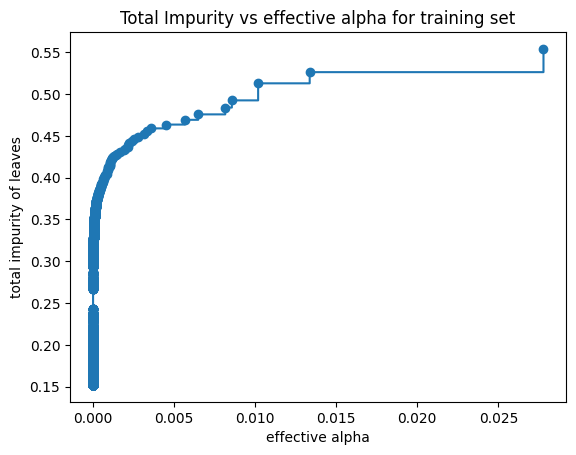

Start searching best ccp alphas


100%|██████████| 45/45 [13:46<00:00, 18.37s/it]


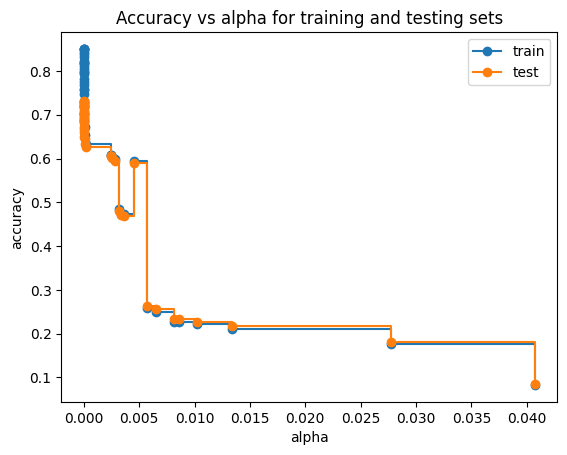

best accuracy val: train 0.8494553703981718 ,0.7308513477448626
Лучший коэф для прунинга 5.560281795081374e-06

Карьерная ступень по Классификатору ФОИР

Start compute cost_complexity_pruning_path


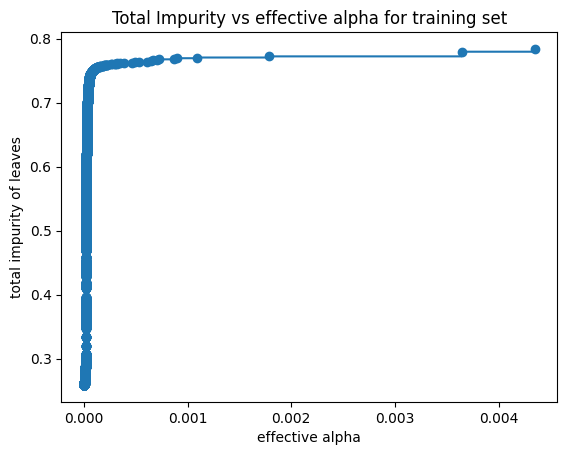

Start searching best ccp alphas


100%|██████████| 45/45 [22:11<00:00, 29.59s/it]


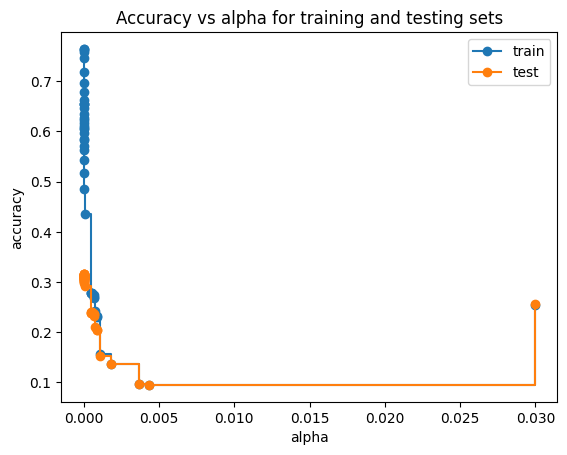

best accuracy val: train 0.7467180436704532 ,0.31631972244462236
Лучший коэф для прунинга 8.340422692622062e-06



In [12]:
# find best hyper params
pipes = []

for i, task in enumerate(tasks):
    print(task)
    print()
    
    
    if i <= 1:
        best_ccp = find_best_ccp_aplpha(X_train, y_train[i], X_val, y_val[i])
        
        
        pipe = ExtraTreesClassifier(class_weight='balanced_subsample', 
                                    oob_score=True, 
                                    bootstrap=True, 
                                    n_jobs=5, 
                                    ccp_alpha=best_ccp)
        
    else:
        y_pred = pipes[0].predict(X_train)
        best_ccp = find_best_ccp_aplpha(np.hstack([X_train, pipes[0].predict(X_train).reshape(-1, 1)]), y_train[i], 
                                        np.hstack([X_val, pipes[0].predict(X_val).reshape(-1, 1)]), y_val[i])
        
        pipe = StackingClassifier(estimators=[('pred_extract', pipes[0])], 
                                  final_estimator=ExtraTreesClassifier(class_weight='balanced_subsample', 
                                           oob_score=True,
                                           bootstrap=True, 
                                           n_jobs=5, 
                                           ccp_alpha=best_ccp), 
                                  cv='prefit',
                                  passthrough=True)
    
    # print('точность :', cross_val_score(pipe, X_train.copy(), y_train[i], n_jobs=1))
    pipe = pipe.fit(X_train, y_train[i])
    pipes.append(pipe)
    print()


In [13]:
%matplotlib inline

In [14]:
df[df['Сфера деятельности по Классификатору ФОИР'] == 'Не работаю']

,Номер,Пол,Дата рождения,Федеральный округ,Регион,Страна проживания,Место работы,Наименование текущей должности,Уровень образования,Карьерная ступень по Классификатору ФОИР,Наименование выбранной типовой должности,Сфера деятельности по Классификатору ФОИР,Соответствует ли выбранная типовая текущей должности,Ручная проверка карьерной ступени,Разница по итогам проверки,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,Категория из реестра СМП,Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,Тип по ОКОГУ,"Уставный капитал, сумма","Уставный капитал, тип",age,label_a,label_b
29,8803972482,Мужской,1981-10-09,Центральный ФО,Москва,Россия,Пропущенное значение,Пропущенное значение,Два и более высших образований,12,Не работаю,Не работаю,Полный аналог,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,2,10
47,7521361416,Мужской,1982-10-04,Центральный ФО,Москва,Россия,Пропущенное значение,Пропущенное значение,Два и более высших образований,12,Не работаю,Не работаю,Не работаю,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.0,2,10
78,8667523084,Мужской,1978-04-02,Центральный ФО,Москва,Россия,Пропущенное значение,Пропущенное значение,"Высшее, специалитет, магистратура",12,Не работаю,Не работаю,Не работаю,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,2,10
102,1674241216,Мужской,1985-12-04,Центральный ФО,Московская,Россия,Пропущенное значение,Пропущенное значение,"Высшее, специалитет, магистратура",12,Не работаю,Не работаю,Не работаю,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,2,10
162,6517873964,Мужской,1974-07-03,Центральный ФО,Москва,Россия,"ООО ""Рубин""",Генеральный директор,Два и более высших образований,12,Не работаю,Не работаю,Не нашел аналогичную должность,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.0,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75220,5275533298,NaN,NaT,NaN,NaN,NaN,Пропущенное значение,Пропущенное значение,Среднее общее,12,Не работаю,Не работаю,Не работаю,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,10
75226,9551632258,Мужской,1980-01-04,NaN,NaN,Эквадор,.,.,"Высшее, специалитет, магистратура",12,Не работаю,Не работаю,Не нашел аналогичную должность,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,2,10
75233,5767632914,Мужской,1995-08-08,NaN,NaN,Казахстан,Пропущенное значение,Пропущенное значение,"Высшее, бакалавриат",12,Не работаю,Не работаю,Не работаю,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,2,10
75235,7339537870,Мужской,1995-03-17,Центральный ФО,Белгородская,Россия,Пропущенное значение,Пропущенное значение,Два и более высших образований,12,Не работаю,Не работаю,Не работаю,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,2,10


              precision    recall  f1-score   support

           0       0.40      0.43      0.41       868
           1       0.88      0.78      0.83      9102
           2       0.45      0.86      0.59      1285
           3       0.49      0.32      0.39       508
           4       0.82      0.71      0.76       366
           5       0.63      0.71      0.66      1662
           6       0.80      0.69      0.74       490
           7       0.71      0.61      0.66       707

    accuracy                           0.73     14988
   macro avg       0.65      0.64      0.63     14988
weighted avg       0.76      0.73      0.74     14988



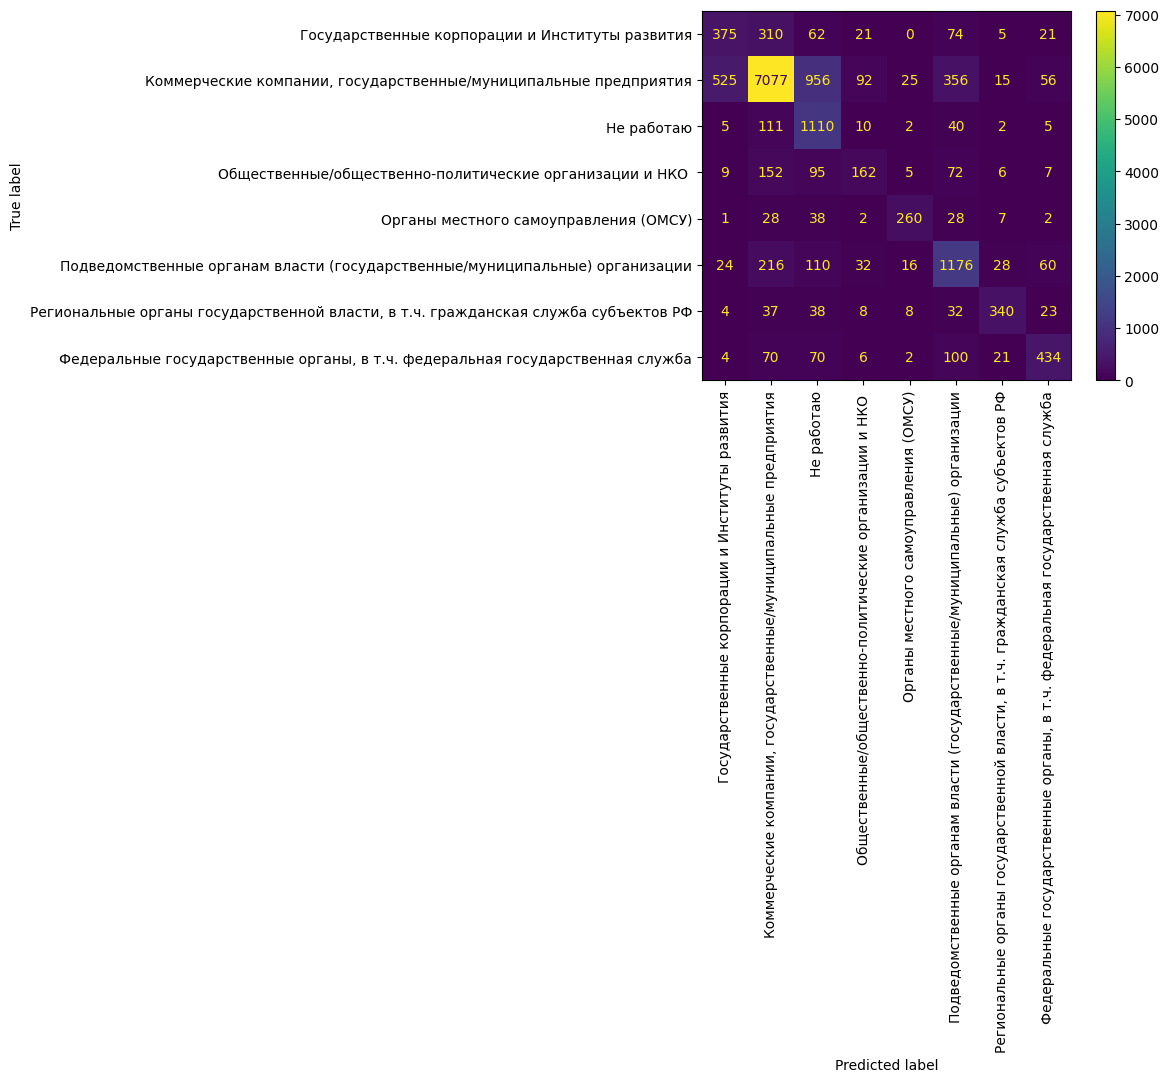

In [15]:
   
# compute metrics
metrics(pipes[0], X_val, y_val[0], LE[0])

              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.33      0.14      0.20         7
           4       1.00      0.92      0.96        39
           5       0.38      0.67      0.48        12
           6       0.91      0.87      0.89        94
           7       0.97      0.83      0.90       127

    accuracy                           0.83       287
   macro avg       0.54      0.51      0.51       287
weighted avg       0.91      0.83      0.86       287



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


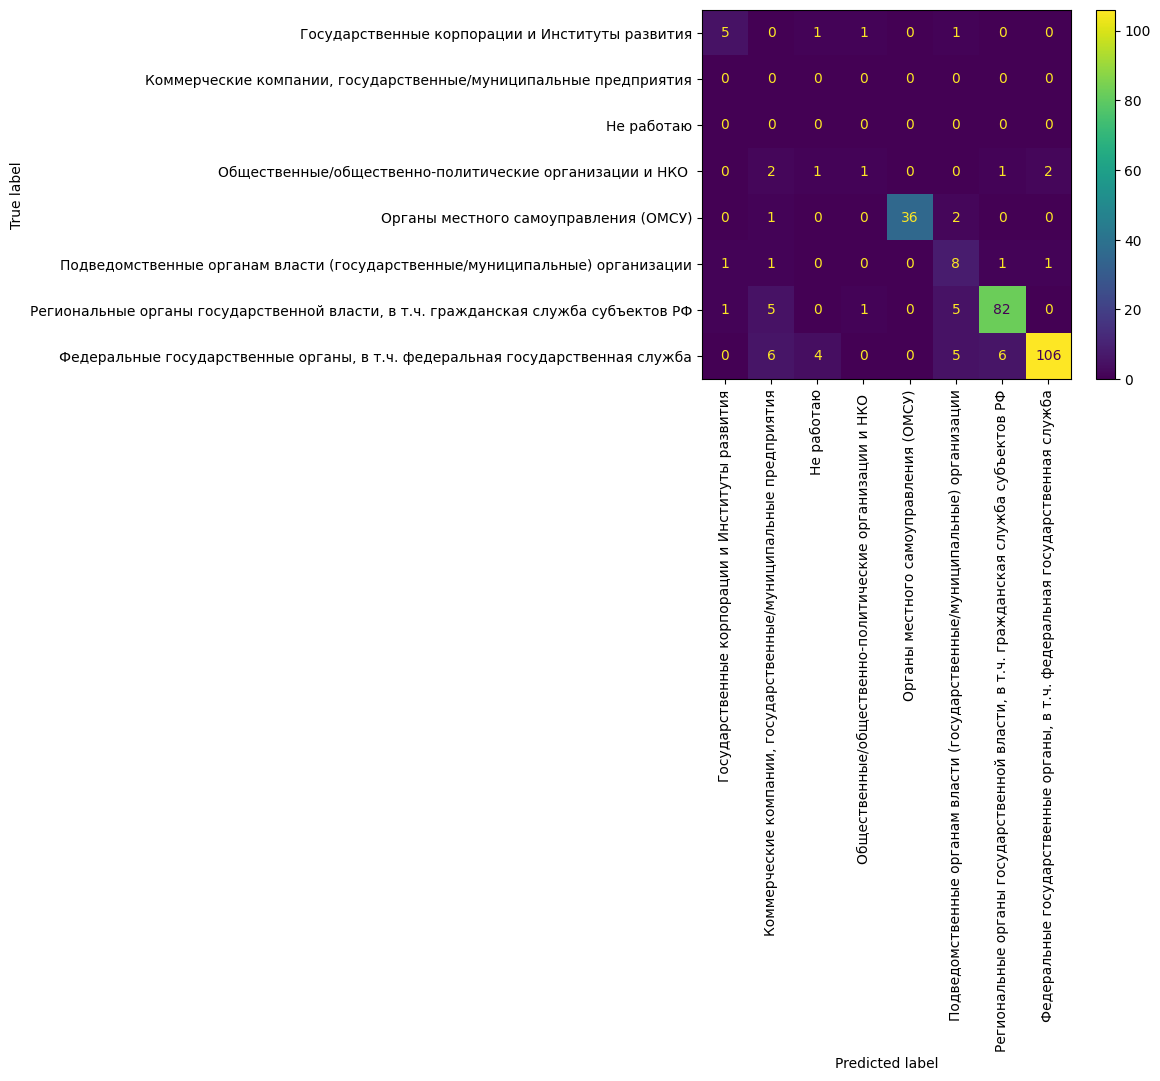

In [16]:
metrics(pipes[0], X_test, y_test[0], LE[0])


              precision    recall  f1-score   support

           0       0.38      0.38      0.38      3753
           1       0.29      0.24      0.26      2901
           2       0.41      0.33      0.36      3845
           3       0.19      0.17      0.18       661
           4       0.17      0.08      0.11      1549
           5       0.03      0.03      0.03       349
           6       0.04      0.05      0.04       302
           7       0.06      0.10      0.08       222
           8       0.01      0.01      0.01        85
           9       0.01      0.14      0.01        36
          10       0.44      0.86      0.59      1285

    accuracy                           0.32     14988
   macro avg       0.18      0.22      0.19     14988
weighted avg       0.32      0.32      0.31     14988



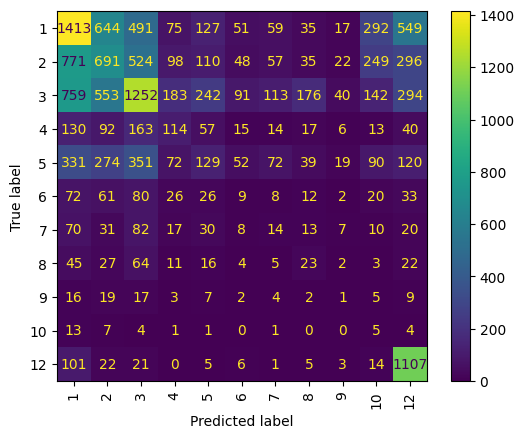

In [17]:
metrics(pipes[1], X_val, y_val[1], LE[1])

/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.12      0.38      0.19        16
           1       0.22      0.35      0.27        46
           2       0.11      0.15      0.12        34
           3       0.21      0.32      0.26        38
           4       0.22      0.13      0.16        38
           5       0.10      0.13      0.11        15
           6       0.00      0.00      0.00         9
           7       1.00      0.02      0.03        57
           8       0.67      0.11      0.19        18
           9       0.00      0.00      0.00        16
          10       0.00      0.00      0.00         0

    accuracy                           0.17       287
   macro avg       0.24      0.14      0.12       287
weighted avg       0.36      0.17      0.15       287



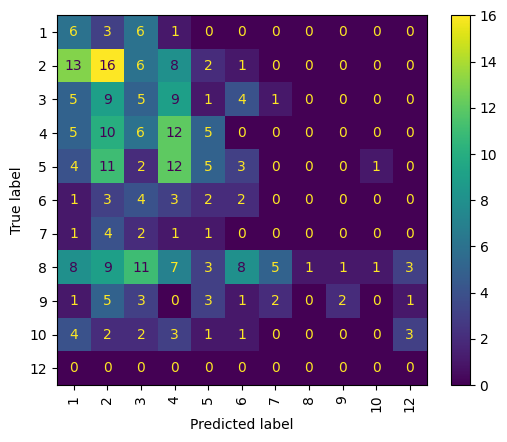

In [18]:
metrics(pipes[1], X_test, y_test[1], LE[1])

Проверим качество только по данным из 2х колонок

In [21]:
df_val[['Пол', 'Регион', 'Страна проживания', 'Уровень образования', 'Федеральный округ']] = None

In [22]:
df_val

,"Вид экономической деятельности, ОКВЭД",Доп вид экономической деятельности_1,Доп вид экономической деятельности_2,Доп вид экономической деятельности_3,"Уставный капитал, тип",Тип по ОКОГУ,Категория из реестра СМП,Пол,Регион,Страна проживания,Уровень образования,Федеральный округ,Место работы,Наименование текущей должности,"Уставный капитал, сумма",Среднесписочная численность сотрудников,Сумма уплаченных налогов за 2020,age
2940,Разработка компьютерного программного обеспечения,Деятельность консультативная и работы в област...,"Деятельность, связанная с использованием вычис...","Деятельность по обработке данных, предоставлен...",УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,None,None,None,None,None,"ООО ""ДжиДиСи Сервисез""",Руководитель сервисных проектов,2.000000e+06,1567.0,81213905.52,34.0
1473,"Производство чугуна, стали и ферросплавов",Производство прочих цветных металлов,Литье прочих цветных металлов,Ремонт машин и оборудования,УСТАВНЫЙ КАПИТАЛ,Приватизированные предприятия,NaN,None,None,None,None,None,АО Тулачермет,Старший мастер,1.000000e+07,NaN,NaN,42.0
9493,Деятельность полномочных представителей Презид...,NaN,NaN,NaN,NaN,Федеральная антимонопольная служба,NaN,None,None,None,None,None,Крымское УФАС России,Начальник отдела контроля закупок,NaN,NaN,NaN,31.0
9891,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,Банк России (ЦБ РФ),Руководитель направления,NaN,NaN,NaN,40.0
4491,Предоставление социальных услуг без обеспечени...,NaN,NaN,NaN,NaN,Органы исполнительной власти субъектов Российс...,NaN,None,None,None,None,None,ГБУ ТЦСО Чертаново,Заместитель директора,NaN,NaN,NaN,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15520,"Добыча камня, песка и глины","Добыча декоративного и строительного камня, из...","Разработка гравийных и песчаных карьеров, добы...",Производство товарного бетона,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",NaN,None,None,None,None,None,"АО ""ЛСР.Базовые""",Заместитель директора по производству,7.596590e+08,NaN,NaN,46.0
12703,Деятельность органов местного самоуправления п...,NaN,NaN,NaN,NaN,Местные администрации (исполнительно-распоряди...,NaN,None,None,None,None,None,Управление имущественных и земельных отношений...,Заведующий планово-экономическим отделом,NaN,NaN,NaN,43.0
10005,"Производство радиолокационной, радионавигацион...",Производство бытовых электрических приборов,Производство бытовых неэлектрических приборов,"Производство прочих изделий, не включенных в д...",УСТАВНЫЙ КАПИТАЛ,Приватизированные предприятия,NaN,None,None,None,None,None,"АО ""ППО ЭВТ им. В.А. Ревунова""",Главный эколог,1.299997e+09,NaN,NaN,38.0
12770,Консультирование по вопросам коммерческой деят...,Деятельность полиграфическая и предоставление ...,Торговля оптовая прочими потребительскими това...,Торговля оптовая прочей офисной техникой и обо...,УСТАВНЫЙ КАПИТАЛ,"Организации, учрежденные юридическими лицами и...",МИКРОПРЕДПРИЯТИЕ,None,None,None,None,None,"ООО ""Учебный центр Финам-Ростов""",Директор,1.000000e+04,9.0,1567822.39,35.0


In [23]:
X_val = data_prepare.transform(df_val)

  0%|          | 0/106 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/106 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  column_tokens = {k: torch.tensor(v).to(self.device) for k, v in tokenized.items()}
  0%|          | 0/106 [00:00<?, ?it/s]/home/admin01/vadim/classifier/utils.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

              precision    recall  f1-score   support

           0       0.38      0.63      0.48       840
           1       0.39      0.24      0.29       677
           2       0.39      0.57      0.46       922
           3       0.46      0.22      0.30       210
           4       0.43      0.11      0.18       440
           5       0.00      0.00      0.00        91
           6       0.00      0.00      0.00        81
           7       0.00      0.00      0.00        49
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00        27

    accuracy                           0.39      3361
   macro avg       0.19      0.16      0.16      3361
weighted avg       0.37      0.39      0.35      3361



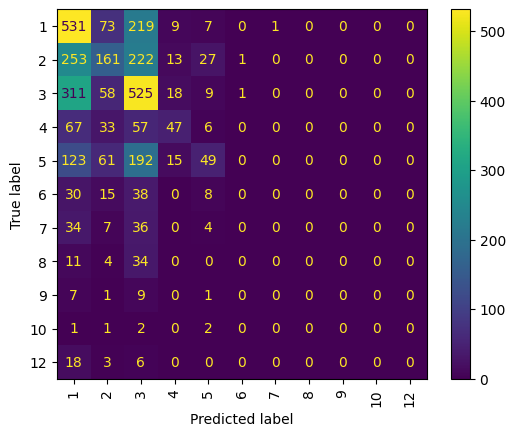

In [24]:
metrics(pipes[1], X_val, y_val[1], LE[1])

              precision    recall  f1-score   support

           0       0.59      0.30      0.40       206
           1       0.91      0.88      0.89      1793
           2       0.00      0.00      0.00        27
           3       0.77      0.45      0.57       125
           4       0.87      0.85      0.86       144
           5       0.62      0.89      0.73       613
           6       0.87      0.83      0.85       250
           7       0.75      0.67      0.70       203

    accuracy                           0.81      3361
   macro avg       0.67      0.61      0.63      3361
weighted avg       0.81      0.81      0.80      3361



/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/admin01/vadim/classifier/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

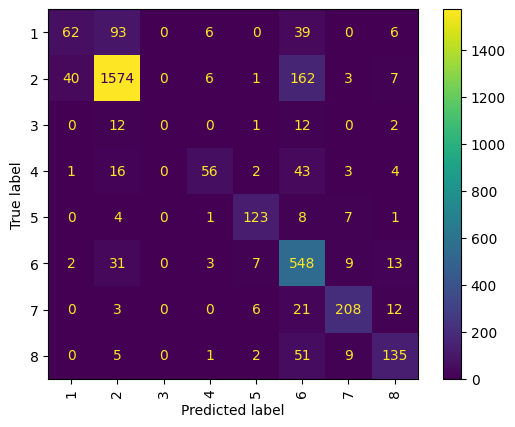

In [25]:
metrics(pipes[0], X_val, y_val[0], LE[1])

In [26]:
df['label_b'].value_counts(normalize=True)[:5].sum()

0.9199500059516723

In [ ]:

# save pipes and transformer
joblib.dump(pipes, 'models/pipelines.joblib')

# data_prepare.steps[0][1].transformers[1][1].to_device(torch.device('cpu'))
joblib.dump(data_prepare, 'models/data_prepare.joblib')
joblib.dump(LE, 'models/label_encoders.joblib')

print('FINISH')